# Predicting Office Lease Rates in Manhattan

Manhattan is a pretty interesting place, and like all major cities it has an abundance of office buildings. Sometimes you might find yourself in need of your own office, at which point you will either start one in your home or garage, or look for a rental.

However, many office rental listings don't include the price, but many years of research and all of human history suggests that price is one of the most important factors in any purchasing decision. Fortunately, there many listings that do include the price, so we can try to construct a model that estimates the missing data.

The data was obtained from a major commercial real estate site in December 2017, and will not be made available here.

Contents:

<ul>
<li>Overview</li>
<li>Cleaning and Exploration</li>
<li>Feature Discussion</li>
<li>Model Fitting</li>
</ul>

## Overview

Of the 1369 rental rates in $/sf/yr, 830 are "Not Disclosed", for a split of 39.4% disclosed, 60.6% not disclosed. This is not great but some of the not disclosed listings are actually in the same building as disclosed listings, so let's claim to have an even 40% of the price data.

The target variable is <b>rate</b>, while the features are:
<ul>
<li>name: the address of the building the rental unit is located in</li>
<li>building_sqft: the total floor space of the building</li>
<li>property_type: the vast majority are pure office buildings, but some may be medical, industrial or retail oriented</li>
<li>building_class: the DOMA classification from A (best) to C (worst). Only available for pure office buildings</li>
<li>building_age: the age in years</li>
<li>walk_score: the ease of walking near the building, based on nearby amenities</li>
<li>transit_score: ease of access to public transportation.</li>
<li>space_name: the name of the rental unit, usually the floor it's on</li>
<li>space_sqft: the floor space of the rental unit</li>
<li>service_type: the amount of utilities provided</li>
<li>space_use: yes, they're all offices, but there are different kinds of offices</li>
</ul>

This is not a huge number of features

In [1]:
from geopy.geocoders import GoogleV3
import pandas as pd
import numpy as np
import sys
import re
import json
from time import sleep
import unicodedata
geolocator = GoogleV3()

In [2]:
ny_office_lease = pd.read_csv('new-york-ny-lease-office_2017-12-23.csv', index_col=0)
addr_list=np.ndarray.tolist(ny_office_lease.name.unique())

In [3]:
len(ny_office_lease)

1369

In [4]:
ny_office_lease['rate'].value_counts().head(3)

Not Disclosed    830
$65.00 /SF/Yr     30
$55.00 /SF/Yr     24
Name: rate, dtype: int64

In [5]:
ny_office_lease[200:208]

,name,rate,building_sqft,property_type,building_class,building_age,walk_score,transit_score,space_name,space_sqft,service_type,space_use
200,4 Times Sq,Not Disclosed,1861000,Office,A,18,100,100,23rd Floor,"37,768 SF",Negotiable,Office
201,1156 Avenue of the Americas,Not Disclosed,75416,Office,B,106,100,100,4th Floor,"1,630 SF",Negotiable,Office
202,1156 Avenue of the Americas,Not Disclosed,75416,Office,B,106,100,100,5th Floor Ste 5th,"9,448 SF",Negotiable,Office
203,1156 Avenue of the Americas,Not Disclosed,75416,Office,B,106,100,100,6th Floor Ste 620,"3,330 SF",Negotiable,Office
204,1156 Avenue of the Americas,Not Disclosed,75416,Office,B,106,100,100,7th Floor,"5,612 SF",Negotiable,Office
205,45-47 W 27th St,Not Disclosed,66797,Office,B,105,100,100,2nd Floor Ste E2,"5,702 SF",Negotiable,Office
206,45-47 W 27th St,Not Disclosed,66797,Office,B,105,100,100,9th Floor Ste E9,"5,702 SF",Negotiable,Office
207,29 W 35th St,$48.00 /SF/Yr,92950,Office,B,106,99,100,2nd Floor,"8,200 SF",Plus Electric,Office


Only 450 buildings, an average of over 3 listings per building.

In [6]:
len (addr_list)

450

In [7]:
len(np.ndarray.tolist(ny_office_lease[ny_office_lease['rate']!='Not Disclosed'].name.unique()))

225

Again, the data is not ideal, but it is fairly complete with very few missing values in the features. We can certainly obtain more, by using multiple sources and websites and time periods, and compiling them all together. But let's see how information we can extract from these observations with these features.

## Cleaning, Setting Types, Creating Classifications

We have the addresses of each property, which means we can obtain the geographic coordinates. With those, we can label each building with a location classification. It is reasonable to assume that location has a major effect on price.

For the other variables, it is mainly a matter of extracting useful numeric information from strings, and filling in a few missing walk and transit scores that are available from walkscore.com, but for some reason not included in the listings.

### Name/Address - Getting Coordinates and Clustering

The number and street name of an address by themselves generally do not mean much (limited exceptions may include Wall Street, and other famous streets), but the address gives us information about the geographic position of a property through its coordinates. By extracting the coordinates, we can classify by geography via clustering methods such as K Means.

In [8]:
# Getting coordinates for each address (A list of uniques)
# The GoogleV3 engine seems to time out much more than Nominatim but it's much better at handling ambiguity (eg. Seventh = 7th)
# Exception wrapping is used to retry the query in case of failure, and there is constant saving to make sure no
# progress is lost.
# The functions coords_wrapper and collect_coords should be combined. There is really no reason for them to be separate
# and the constant reloading can be avoided, though for smallish files it's not a big deal.
# NOTE: some listings are actually in multiple buildings with an address range such as 191-199. The Google engine returns
# a single set of geographic coordinates for the first or last building in that range. This is fine, since they should be
# within the same cluster anyway.

def get_coord(address):
    print ('Getting' , address)
    geoloc = geolocator.geocode(address)
    sleep(0.5)
    print ('Got ', geoloc, '\n')
    return (geoloc.latitude, geoloc.longitude)
            
def coords_wrapper(addr_list):

    # Start at the beginning of addr_list
    break_point = 0
    
    # Open the file if it exists, otherwise create a new empty file
    try:
        with open('nyc_lease_coordinates.json', 'r') as infile:
            uniques = json.load(infile)
    except:
        with open('nyc_lease_coordinates.json', 'w') as outfile:
            uniques={}
            json.dump(uniques,outfile)
    
    # do while there are still addresses to process
    while(break_point < len(addr_list)):
        # run collect_coords starting with the current breakpoint, and gets the
        # address that it's stuck on
        addr = addr_list[break_point]
        try: 
            try:
                uniques[addr] = get_coord(addr + ' Manhattan')
                # If it works, get to the next one. Once break_point gets to the length of the list, the conditions of
                # the loop will no longer be satisfied, and the loop ends.
                break_point +=1
                sleep(0.5)
            except:
                # If it doesn't work, don't increase the break_point and try again
                print ('Could not get ', addr)
                sleep(0.5)
        except:
            with open('nyc_lease_coordinates.json','w') as outfile:
                json.dump(uniques,outfile)
            sleep(0.5)

    with open('nyc_lease_coordinates.json','w') as outfile:
        json.dump(uniques,outfile)       

In [9]:
ny_office_lease = pd.read_csv('new-york-ny-lease-office_2017-12-23.csv', index_col=0)
addr_list=np.ndarray.tolist(ny_office_lease.name.unique())

In [10]:
#coords_wrapper(addr_list)

In [11]:
with open('nyc_lease_coordinates.json', 'r') as infile:
    uniques = json.load(infile)

ny_office_lease['coords'] = ny_office_lease['name'].map(uniques)
coords=pd.DataFrame(addr_list)[0].map(uniques)
coords = coords.values.tolist()
lats = [i[0] for i in coords]
longs = [i[1] for i in coords]

With this list of unique coordinates, we can use K Means to cluster them around a yet to be determined number of centroids.

In [12]:
from scipy import linalg
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's do an elbow analysis to see the rate of decline of the sum of squared errors from a centroid as the number of centroids increases.

Text(0.5,1,'SSE vs k')

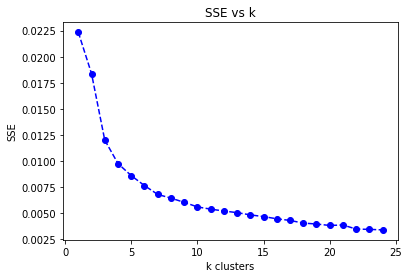

In [13]:
SSE = []
for k in range(1,25):
    km = KMeans(n_clusters=k)
    km.fit(coords)
    labels = km.labels_
    centroids = km.cluster_centers_
    # Get the SSE
    SSE.append(sum(np.min(cdist(coords, centroids, 'euclidean'),axis=1))/len(coords))
    
plt.plot(range(1,25),SSE, 'bo--')
plt.xlabel('k clusters')
plt.ylabel('SSE')
plt.title('SSE vs k')

There is no standout elbow, but let's try 7, as the returns diminish noticeably after that (well, sort of noticeably).

In [14]:
k = 7
km = KMeans(n_clusters=k)
km.fit(coords)
labels = km.labels_
centroids = km.cluster_centers_

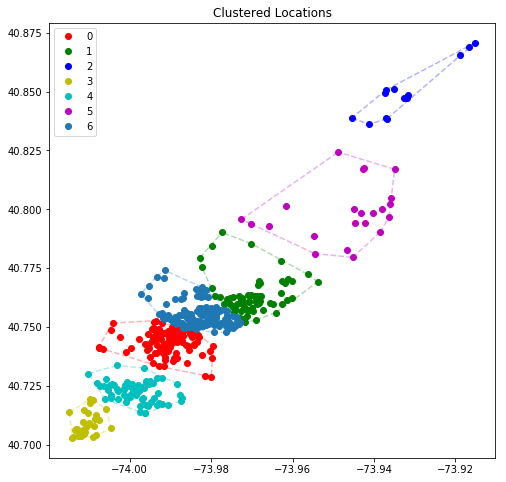

In [15]:
colors = ['r', 'g', 'b', 'y', 'c', 'm','C0','k']
plt.figure(figsize=(8,8))
plt.title('Clustered Locations')
for j in range(k):
    current_coords = np.asarray(coords)[np.where(labels==j)]
    hull = ConvexHull(current_coords)
    j_longs = current_coords[:,1]
    j_lats =  current_coords[:,0]
    plt.plot(j_longs, j_lats, '%so' % colors[j], label=j)
    for simplex in hull.simplices:
        #plt.plot(current_coords[simplex,1],current_coords[simplex,0], '%s--'%colors[j],alpha=0.3)
        plt.plot(current_coords[simplex,1],current_coords[simplex,0], '--', color=colors[j],alpha=0.3)
plt.legend()

In [16]:
ny_office_lease['location_cluster'] = ny_office_lease.name.map(dict(zip(addr_list,labels)))

If we knew all the prices, that would be a very useful third dimension in the clustering, and the 2 dimensional geographic representation will not necessary have contingious clusters (such as in this <a href="http://nbviewer.jupyter.org/github/keithqu/dsp/blob/master/gasprices/gas%20prices.ipynb">gas prices example</a>). Since the whole point is to estimate unknown rates, we can't do that.

Neighbourhood census data may also give useful information for groupings, as well as for the overall analysis.

In [17]:
ny_office_lease.groupby('location_cluster')['building_sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
location_cluster,,,,,,,,
0,278.0,175994.208633,308523.701281,4614.0,57152.0,107343.0,212000.00,2800118.0
1,215.0,357844.204651,328220.972457,1333.0,102150.0,231647.0,564196.00,2038201.0
2,27.0,65448.777778,102196.190915,2498.0,17987.5,39500.0,46865.00,345000.0
3,124.0,806328.782258,588863.910494,10836.0,417068.0,647924.0,984000.00,3600000.0
4,140.0,142487.914286,215734.956242,3875.0,19771.5,41361.0,187001.25,1163051.0
5,38.0,91648.578947,136895.518663,3200.0,10500.0,26000.0,80508.25,520000.0
6,547.0,485963.897623,488987.146443,5504.0,133700.0,293878.0,765911.00,3143291.0


In [18]:
# cluster 2 roughly corresponds to the area around Central Park (the empty space is noticeable), with the largest buildings
# next up is cluster 3, which contains the World Trade Center and Wall Street.

In [19]:
# There are some bugs with gmplot: the proper colors only show up when zoomed in.

### Rates

Clear up the undisclosed rates to make them empty strings, and convert the string rates into floats. When there is a price range, always use the lowest (and for consistency do the same when there is an area range for each rental space).

In [20]:
ny_office_lease['rate'] = ny_office_lease['rate'].replace('Not Disclosed','')

In [21]:
# Get the highest rate from the range of rates if it exists, otherwise keep it at ''
def get_float_rate (string_rate):
    if string_rate != '':
        float_rate = float(string_rate.strip().split()[0].replace('$',''))
    else:
        float_rate = ''
    return float_rate

In [22]:
ny_office_lease['rate'] = ny_office_lease['rate'].apply(lambda r: get_float_rate(r))

In [23]:
# Now convert the empty cells to null to make the rate column consistently float64
ny_office_lease['rate'] = ny_office_lease['rate'].replace('',pd.NaT)

In [24]:
ny_office_lease['rate']=pd.to_numeric(ny_office_lease['rate'], errors='coerce')

Text(0.5,1,'Average rates by cluster, and descriptive')

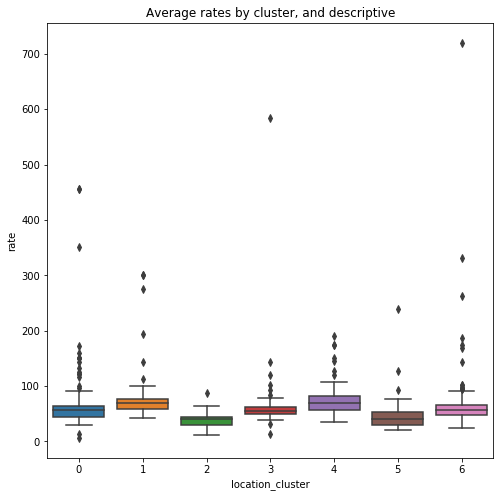

In [25]:
fig,ax=plt.subplots(ncols=1, figsize=(8,8))
sns.boxplot(x='location_cluster',y='rate',data=ny_office_lease)
plt.title('Average rates by cluster, and descriptive')

With the rate column appropriately convert to float, we can get an idea of the prices in each region.

It seems like there are enough differences in the prices to warrant having these classes.

### Building Class

BOMA defines building classes as follows:

>Class A<br>
>Most prestigious buildings competing for premier office users with rents above average for the area. Buildings have high quality standard finishes, state of the art systems, exceptional accessibility and a definite market presence.

>Class B<br>
>Buildings competing for a wide range of users with rents in the average range for the area. Building finishes are fair to good >for the area. Building finishes are fair to good for the area and systems are adequate, but the building does not compete with >Class A at the same price.

>Class C<br>
>Buildings competing for tenants requiring functional space at rents below the average for the area.

In [26]:
ny_office_lease.groupby('location_cluster')['building_class'].describe()

,count,unique,top,freq
location_cluster,,,,
0,250,3,B,144
1,181,3,A,139
2,14,2,B,8
3,122,3,A,75
4,101,3,B,59
5,13,2,C,12
6,530,3,A,269


There are also many buildings with no classification, but it can be see that the unclassified buildings are not pure office properties, and so assigning them our own classification 'D' might actually serve some purpose.

In [27]:
ny_office_lease.loc[ny_office_lease['building_class'].isnull(),'building_class'] = 'D'

We can see that on average, classes A, B and C are appropriately priced based on their rated quality, but there are huge major outliers for classes B and C.

Text(0.5,1,'All rates by building class')

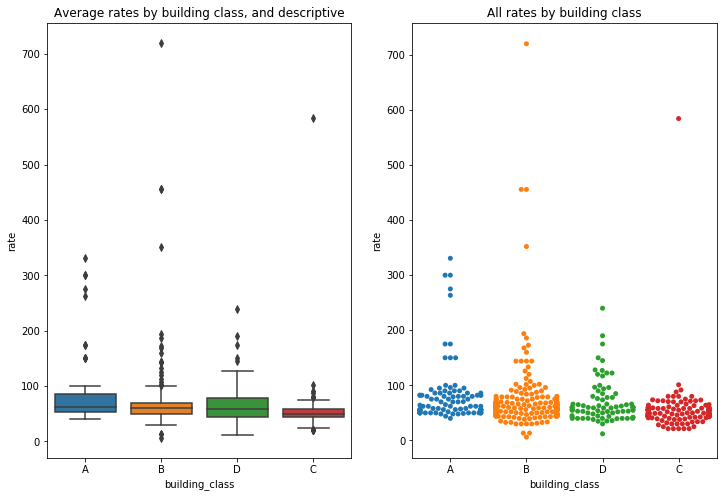

In [28]:
fig,ax=plt.subplots(ncols=2, figsize=(12,8))
plt.subplot(1,2,1)
sns.boxplot(x='building_class',y='rate',data=ny_office_lease)
plt.title('Average rates by building class, and descriptive')
plt.subplot(1,2,2)
sns.swarmplot(x='building_class',y='rate',data=ny_office_lease)
plt.title('All rates by building class')

### Walk and Transit Scores

Walk and transit scores are composites of features such as distance from public transportation, number of intersections, and traffic on a scale from 0 (worst) to 100 (best).

Conventiently, there are no buildings with one but not the other. They are also all in building_class D, so they are not pure office buildings. The scores actually seem to be available from walkscores.com, so we can input them manually.

In [29]:
ny_office_lease.loc[671,'walk_score'] = 97
ny_office_lease.loc[671,'transit_score'] = 100

ny_office_lease.loc[678,'walk_score'] = 99
ny_office_lease.loc[678,'transit_score'] = 100
ny_office_lease.loc[679,'walk_score'] = 99
ny_office_lease.loc[679,'transit_score'] = 100
ny_office_lease.loc[680,'walk_score'] = 99
ny_office_lease.loc[680,'transit_score'] = 100

ny_office_lease.loc[973,'walk_score'] = 98
ny_office_lease.loc[973,'transit_score'] = 100

ny_office_lease.loc[1043,'walk_score'] = 99
ny_office_lease.loc[1043,'transit_score'] = 100
ny_office_lease.loc[1044,'walk_score'] = 99
ny_office_lease.loc[1044,'transit_score'] = 100
ny_office_lease.loc[1045,'walk_score'] = 99
ny_office_lease.loc[1045,'transit_score'] = 100
ny_office_lease.loc[1046,'walk_score'] = 99
ny_office_lease.loc[1046,'transit_score'] = 100

ny_office_lease.loc[1320,'walk_score'] = 46
ny_office_lease.loc[1320,'transit_score'] = 0

In [30]:
ny_office_lease.groupby('location_cluster')['walk_score'].describe()

,count,mean,std,min,25%,50%,75%,max
location_cluster,,,,,,,,
0,278.0,98.967626,3.487320,46.0,99.0,100.0,100.0,100.0
1,215.0,99.800000,0.612944,95.0,100.0,100.0,100.0,100.0
2,27.0,97.074074,2.368478,92.0,96.0,98.0,99.0,100.0
3,124.0,99.798387,0.569978,97.0,100.0,100.0,100.0,100.0
4,140.0,99.835714,0.408731,98.0,100.0,100.0,100.0,100.0
5,38.0,97.315789,2.302822,92.0,97.0,98.0,99.0,100.0
6,547.0,99.475320,0.974413,88.0,99.0,100.0,100.0,100.0


In [31]:
ny_office_lease.groupby('location_cluster')['transit_score'].describe()

,count,mean,std,min,25%,50%,75%,max
location_cluster,,,,,,,,
0,278.0,99.640288,5.997601,0.0,100.0,100.0,100.0,100.0
1,215.0,99.944186,0.330181,98.0,100.0,100.0,100.0,100.0
2,27.0,96.777778,3.522819,90.0,92.5,99.0,99.0,99.0
3,124.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
4,140.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
5,38.0,99.763158,0.998220,94.0,100.0,100.0,100.0,100.0
6,547.0,99.983547,0.311124,93.0,100.0,100.0,100.0,100.0


In general these scores in Manhattan are extremely high.

### Building Size

The data does not contain the number of floors for each building, but in this region there should be a high correlation between total floor area and height. There is in nothing in Manhattan like the Pentagon, which has over 6.6 million square feet of floor space and only 7 above-ground floors.

We can immediately see a correlation between average size and building class for classes A, B and C.

If this is included as a feature for prices, we can either use arbitrary size classes, or use a combination of measuring by 1000 square feet and normalization.

In [32]:
ny_office_lease.groupby('building_class')['rate'].describe()

,count,mean,std,min,25%,50%,75%,max
building_class,,,,,,,,
A,93.0,83.246129,57.135397,40.00,54.00,62.00,86.0,330.61
B,229.0,72.030131,65.104618,6.00,50.00,60.00,70.0,720.00
C,139.0,54.680647,47.420259,21.33,44.00,49.00,58.0,584.28
D,78.0,69.633333,38.699070,11.96,44.55,59.03,78.0,240.00


We should log linearize building size, since this effectively removes outliers and smooths the data.

In [33]:
ny_office_lease['log_building_sqft'] = np.log(ny_office_lease['building_sqft'])

In [34]:
ny_office_lease.groupby('building_class')['log_building_sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
building_class,,,,,,,,
A,528.0,13.312452,0.709457,9.903488,12.886641,13.350614,13.696522,15.096444
B,490.0,11.748973,0.972249,8.579604,11.230775,11.859030,12.495004,13.966557
C,193.0,10.782073,1.058689,7.823246,9.865266,11.068153,11.617285,12.873715
D,158.0,10.332363,1.238189,7.195187,9.423839,10.277442,10.995277,13.243157


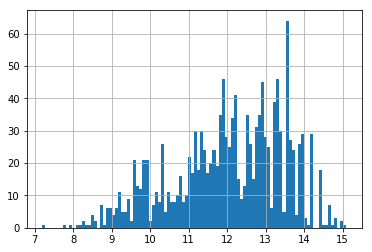

In [35]:
ny_office_lease['log_building_sqft'].hist(bins=100)

Text(0.5,1,'Log building size by cluster and building class')

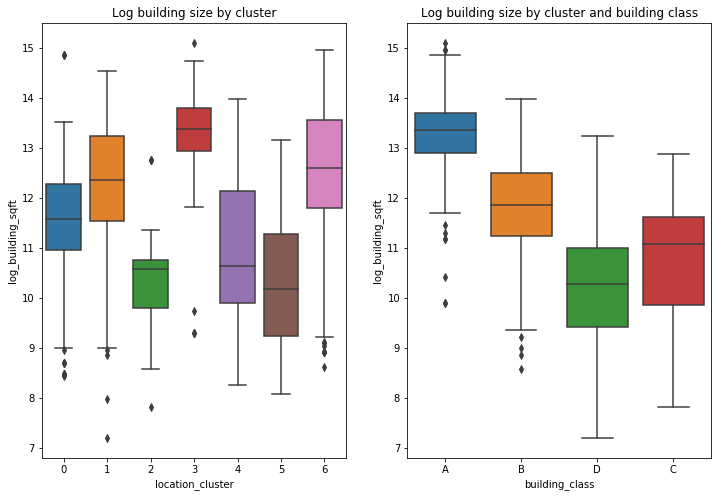

In [36]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
plt.subplot(1,2,1)
sns.boxplot(x='location_cluster',y='log_building_sqft',data=ny_office_lease)
plt.title('Log building size by cluster')
plt.subplot(1,2,2)
sns.boxplot(x='building_class',y='log_building_sqft',data=ny_office_lease)
plt.title('Log building size by cluster and building class')

The largest building, 55 Water St, was the largest office building in the world when it was completed in 1972. The smallest, at 1005 Second Ave, is a narrow 4-storey storefront with an Italian restaurant on the ground floor, a second floor spa, and an apartment occupying the top 2 floors.

### Rental Unit Area

Like with rental rates, I'm simply going to use the highest unit area when there is a range. Almost all of them have an undisclosed price, so we're estimating anyway.

In [37]:
ny_office_lease['space_sqft'] = ny_office_lease['space_sqft'].apply(lambda a:int(a.strip().split()[0].replace(',','')))

In [38]:
ny_office_lease.groupby('building_class')['space_sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
building_class,,,,,,,,
A,528.0,10821.517045,15985.617475,40.0,1853.75,5879.0,16445.25,260000.0
B,490.0,3894.195918,4723.911066,40.0,909.50,2332.0,5082.75,30216.0
C,193.0,2854.839378,2682.508900,70.0,1000.00,2200.0,3750.00,16909.0
D,158.0,3102.310127,3051.524720,144.0,833.25,1814.0,4300.00,14290.0


In [39]:
ny_office_lease.groupby('location_cluster')['space_sqft'].describe()

,count,mean,std,min,25%,50%,75%,max
location_cluster,,,,,,,,
0,278.0,3768.176259,4332.201566,50.0,902.25,2400.0,5625.00,26782.0
1,215.0,4928.986047,6196.903267,100.0,972.00,2500.0,6078.50,29802.0
2,27.0,4009.111111,2849.915172,195.0,1464.50,5000.0,5202.50,8750.0
3,124.0,9966.137097,14165.002047,40.0,575.00,3050.5,11088.75,57399.0
4,140.0,6804.357143,10405.705417,100.0,1500.00,2550.0,6425.00,51576.0
5,38.0,10474.342105,41694.292211,400.0,1037.50,3625.0,6034.75,260000.0
6,547.0,7058.681901,8902.770520,40.0,1171.00,3600.0,8997.50,45245.0


The largest rental spaces tend to be entire floors or sections of the building. Regardless of location, class A buildings tend to have the largest rental spaces.

Interestingly, some of the smallest offices are also class A. These are often executive offices. It seems like the relationship between unit area and rate is not monotonic.

Text(0.5,1,'Rate by size of unit space')

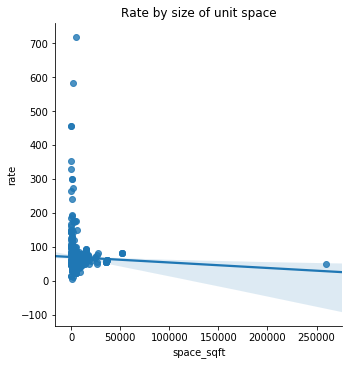

In [40]:
sns.lmplot(x='space_sqft',y='rate',data=ny_office_lease)
plt.title('Rate by size of unit space')

Generally (very, very generally), larger units are cheaper per square footage.

### Space Name/Floor
This is usually the floor number, which might be useful information. But we need to extract it from the text, which might be an ordeal since there is a lack of consistency. However, it can be seen that the first word of each string contains the proper information.

In [41]:
ny_office_lease['space_floor']=ny_office_lease['space_name']

In [42]:
ny_office_lease['space_floor'] = ny_office_lease['space_floor'].apply(lambda w: w.strip().split()[0])

In [43]:
ny_office_lease.loc[ny_office_lease['space_floor'] == 'Ground','space_floor'] = '1'

In [44]:
# Change "Ground" and "Lower" to "1"
ny_office_lease.loc[ny_office_lease['space_floor'] == 'Lower','space_floor'] = '1'

In [45]:
# Now get rid of "th", "rd", "st", "nd"
ny_office_lease['space_floor']=ny_office_lease['space_floor'].apply(lambda w:w.split("th")[0])
ny_office_lease['space_floor']=ny_office_lease['space_floor'].apply(lambda w:w.split("rd")[0])
ny_office_lease['space_floor']=ny_office_lease['space_floor'].apply(lambda w:w.split("nd")[0])
ny_office_lease['space_floor']=ny_office_lease['space_floor'].apply(lambda w:w.split("st")[0])

In [46]:
ny_office_lease.groupby('space_floor')['rate'].describe().head()

,count,mean,std,min,25%,50%,75%,max
space_floor,,,,,,,,
1,75.0,87.796133,61.637306,11.96,48.50,66.0,100.0,300.0
10,21.0,56.884286,11.167416,36.00,47.00,59.0,65.0,82.0
11,5.0,53.240000,8.371858,42.00,47.20,56.0,59.0,62.0
12,14.0,57.285714,9.522674,44.00,50.25,55.5,65.0,75.0
13,6.0,59.500000,11.022704,45.00,51.75,61.0,65.0,75.0


How can these be classified? It's going to be somewhat arbitrary:
>"base": basement

>"lower": Meazzaine, Concourse, Floors 1-5

>"mid": 5-14

>"high": 15-24

>"upper": 25+, Pent

In [47]:
def floor_class (floor):
    if floor == 'Basement':
        return 'base'
    elif floor == 'Concourse':
        return 'lower'
    elif floor == 'Mezzanine':
        return 'lower'
    elif floor == 'Pen':
        return 'upper'
    else:
        floor = int(floor)
        if floor < 5:
            return 'lower'
        elif floor < 15:
            return 'mid'
        elif floor < 25:
            return 'high'
        else:
            return 'upper'
    return None

In [48]:
ny_office_lease['floor_class'] = ny_office_lease['space_floor'].apply(lambda fl:floor_class(fl))

Text(0.5,1,'Rental rate by floor of rental unit')

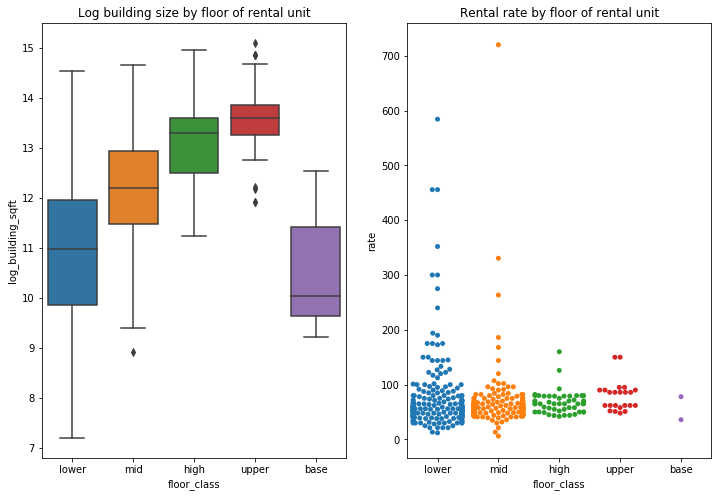

In [49]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
plt.subplot(1,2,1)
sns.boxplot(x='floor_class',y='log_building_sqft',data=ny_office_lease)
plt.title('Log building size by floor of rental unit')
plt.subplot(1,2,2)
sns.swarmplot(x='floor_class',y='rate',data=ny_office_lease)
plt.title('Rental rate by floor of rental unit')

### Service Type
Utilities, etc.

"Negotiable" and "to be determined" might be combinable. On the other hand, it might be determined to not be negotiable, so we can only do some limited groupings.

In [50]:
# these are fine
ny_office_lease.loc[ny_office_lease['service_type'] == 'Modified Gross','service_type'] = 'mod_gross'
ny_office_lease.loc[ny_office_lease['service_type'] == 'Plus Electric','service_type'] = 'elec'

# put these together
ny_office_lease.loc[ny_office_lease['service_type'] == 'Tenant Electric','service_type'] = 'elec'
ny_office_lease.loc[ny_office_lease['service_type'] == 'Plus Electric And Cleaning','service_type'] = 'elec'
ny_office_lease.loc[ny_office_lease['service_type'] == 'Plus All Utilities','service_type'] = 'elec'

# Put net, triple net in net
ny_office_lease.loc[ny_office_lease['service_type'] == 'Net','service_type'] = 'net'
ny_office_lease.loc[ny_office_lease['service_type'] == 'Triple Net','service_type'] = 'net'

# Put tbd, neg in tbd
ny_office_lease.loc[ny_office_lease['service_type'] == 'To Be Determined','service_type'] = 'tbd'
ny_office_lease.loc[ny_office_lease['service_type'] == 'Negotiable','service_type'] = 'tbd'

ny_office_lease.loc[ny_office_lease['service_type'] == 'Full Service Gross','service_type'] = 'fsg'

In [51]:
ny_office_lease.groupby('service_type')['rate'].describe()

,count,mean,std,min,25%,50%,75%,max
service_type,,,,,,,,
elec,165.0,62.591576,46.017399,21.33,48.00,58.0,65.0000,584.28
fsg,76.0,98.268289,111.225982,6.00,50.00,63.0,91.4775,720.00
mod_gross,246.0,64.455610,36.406544,11.96,47.05,56.0,70.0000,300.00
net,43.0,65.988605,34.812040,25.00,45.00,56.0,80.0000,186.00
tbd,9.0,86.578889,37.058616,42.00,60.00,70.0,117.0000,150.00


### Space Use
>"Executive": Office(Executive Suite), Office/Medical(Executive Suite)

>"Office": keep

>"Retail": keep

>"Medical": keep

>"Mixed": Office/Medical, Office/Retail

In [54]:
ny_office_lease.loc[ny_office_lease['space_use'] == 'Office(Executive Suite)','space_use'] = 'executive'
ny_office_lease.loc[ny_office_lease['space_use'] == 'Office/Medical(Executive Suite)','space_use'] = 'executive'
ny_office_lease.loc[ny_office_lease['space_use'] == 'Office/Medical','space_use'] = 'mixed'
ny_office_lease.loc[ny_office_lease['space_use'] == 'Office/Retail','space_use'] = 'mixed'
ny_office_lease.loc[ny_office_lease['space_use'] == 'Medical','space_use'] = 'mixed'
ny_office_lease.loc[ny_office_lease['space_use'] == 'Office','space_use'] = 'office'
ny_office_lease.loc[ny_office_lease['space_use'] == 'Retail','space_use'] = 'retail'

In [55]:
ny_office_lease['space_use'].unique()

array(['office', 'mixed', 'executive', 'retail'], dtype=object)

Text(0.5,1,'Rate by type by building class')

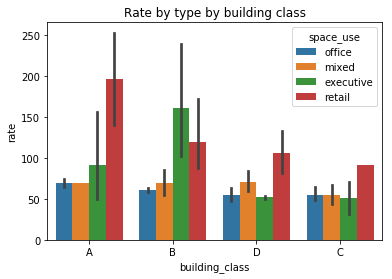

In [56]:
sns.barplot(x='building_class', y='rate', hue='space_use', data=ny_office_lease)
plt.title('Rate by type by building class')

Retail tends to be the most expensive in all classes but B, but we saw that class B had some major executive office outliers above.

### Building age
This seems to be all over the place. There are many old historical buildings that are well maintained and clearly not falling apart. This doesn't seem to be too big of a deal for Manhattan.

Within each location cluster, there doesn't seem to be much of a relationship between building age and rental rate either.

Text(0.5,1,"Doesn't seem to be anything there")

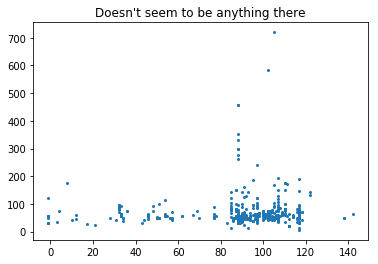

In [57]:
plt.plot(ny_office_lease['building_age'], ny_office_lease['rate'], 'o', markersize=2)
plt.title("Doesn't seem to be anything there")

## Feature Transformations


### Rate/sqft/year -> Monthly Rent

With some significant outliers, overall the rate does not seem to depend too much on unit size, and so on average lease rates increase linearly with square footage.

We will try something risky by geting the log monthly rental rates. Essentially, we are transforming our target variable into a more informative value, but in doing so we are making it directly a function of a feature. However, it is a direct function of the feature <i>only</i> in the training set.

This is risky because this will inevitably decrease our training variances and errors, but could easily lead to overfitting on our training set if the effects of the other features are not brought into prominence.

Text(27.0568,0.5,'Rate')

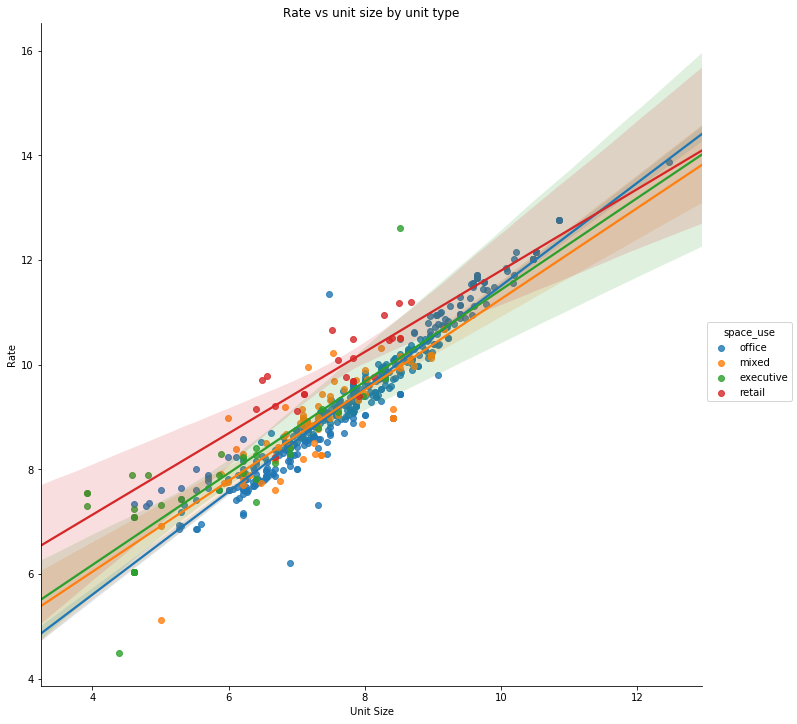

In [58]:
ny_office_lease['log_monthly_rate'] = np.log(ny_office_lease['rate'] * ny_office_lease['space_sqft'] / 12)
ny_office_lease['log_space_sqft'] = np.log(ny_office_lease['space_sqft'])

sns.lmplot(x='log_space_sqft',y='log_monthly_rate',hue='space_use',data=ny_office_lease, size=10,aspect=1)
plt.title('Rate vs unit size by unit type')
plt.xlabel('Unit Size')
plt.ylabel('Rate')

### Building size relative to cluster mean

The size of a building compared to its neighbours could have an effect on price. If building height data or highest floor were known, we could also find the relative height of a building. However, there should be high correlation between total building floor space and height within a cluster (e.g. in a cluster with mostly skyscrapers, it's unlikely there will be a building like the Pentagon, with only 5 above ground storeys but millions of square feet in floors). Size/height past a certain point could have prestige attached to it: a 55 storey building might be more prestigious than a 50 storey one, but 10 and 15 aren't too different.

The area variables have already been log transformed, so this variable is just log(building_sqft) - log(cluster mean).

In [59]:
cluster_mean_sqft = dict(zip(range(k),ny_office_lease.groupby('location_cluster')['building_sqft'].describe()['mean']))

In [60]:
ny_office_lease['cluster_mean_sqft'] = np.log(ny_office_lease['location_cluster'].map(cluster_mean_sqft))

In [61]:
ny_office_lease['building_rel_size'] = ny_office_lease['log_building_sqft'] - ny_office_lease['cluster_mean_sqft']

The information given by this new measure is similar, but changes some of the orderings.

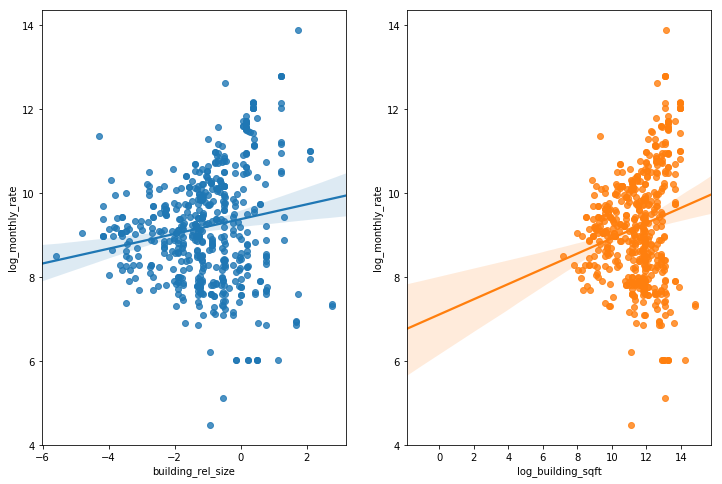

In [62]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,8))
sns.regplot(x='building_rel_size',y='log_monthly_rate',data=ny_office_lease, ax=ax1)

sns.regplot(x='log_building_sqft',y='log_monthly_rate',data=ny_office_lease, ax=ax2)

The fit is still not great, but gives us different information than just the size of the building.

### Building size relative to same class
My class A building is bigger/better than your class A building! Or is it?

In [63]:
building_class_mean_sqft = dict(ny_office_lease.groupby('building_class')['building_sqft'].describe()['mean'])

In [64]:
ny_office_lease['building_class_mean_sqft'] = np.log(ny_office_lease['building_class'].map(building_class_mean_sqft))

In [65]:
ny_office_lease['building_rel_to_class'] = ny_office_lease['log_building_sqft'] - ny_office_lease['building_class_mean_sqft']

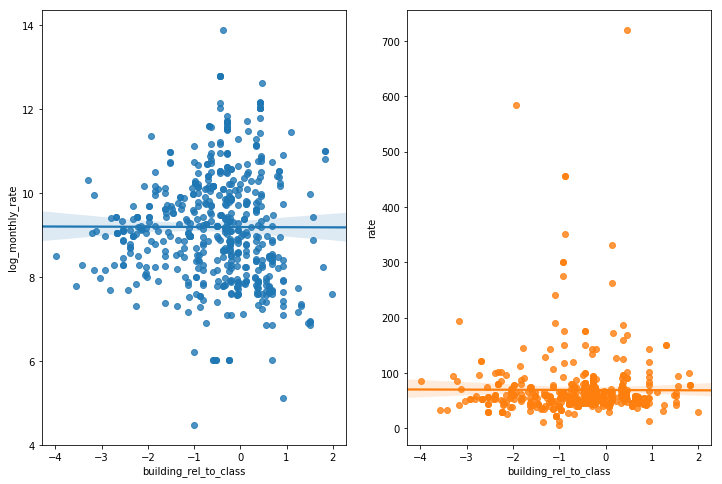

In [66]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,8))
sns.regplot(x='building_rel_to_class',y='log_monthly_rate',data=ny_office_lease, ax=ax1)

sns.regplot(x='building_rel_to_class',y='rate',data=ny_office_lease, ax=ax2)

This does not seem to be a particularly informative measure, so we are not going to include it in the model.

### Unit size relative to others of the same type

Is it not reasonable to assume that, for example, a 200 square foot executive office in midtown will probably cost more than a 100 square foot executive office next door?

In [67]:
space_use_mean_sqft = dict(ny_office_lease.groupby('space_use')['space_sqft'].describe()['mean'])

In [68]:
ny_office_lease['space_use_mean_sqft'] = np.log(ny_office_lease['space_use'].map(space_use_mean_sqft))

In [69]:
ny_office_lease['space_rel_size'] = ny_office_lease['log_space_sqft'] - ny_office_lease['space_use_mean_sqft']

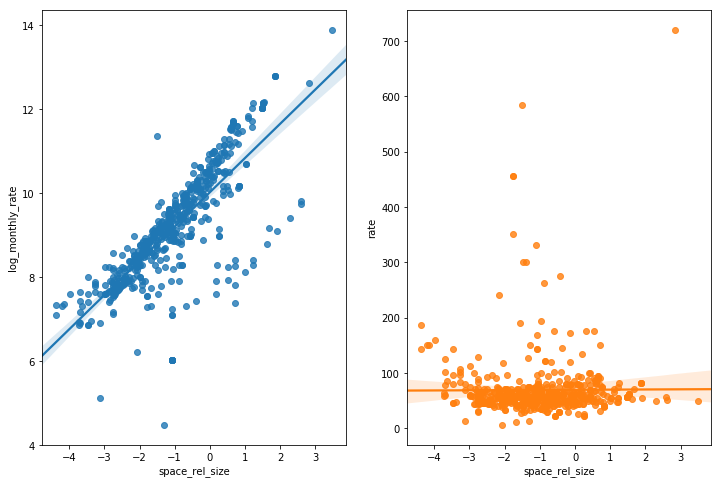

In [70]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,8))
sns.regplot(x='space_rel_size',y='log_monthly_rate',data=ny_office_lease, ax=ax1)

sns.regplot(x='space_rel_size',y='rate',data=ny_office_lease, ax=ax2)

Of course, the general trends are still the same: as floor space increases, monthly rate increases, and $/sqft/year decreases slightly. But it is hoped that this can give us information about size differences specific to a type.

We will include this measure and the relative building size to cluster mean.

## Making dummy variables

In [71]:
def dummify(df, col):
    dummies=pd.get_dummies(df[col], prefix=col, drop_first=False)
    df = pd.concat((df,dummies),axis=1)
    return df

In [72]:
ny_office_lease = dummify(ny_office_lease,'building_class')

In [73]:
ny_office_lease = dummify(ny_office_lease,'location_cluster')

In [74]:
ny_office_lease = dummify(ny_office_lease,'floor_class')

In [75]:
ny_office_lease = dummify(ny_office_lease,'service_type')

In [76]:
ny_office_lease = dummify(ny_office_lease,'space_use')

In [77]:
ny_office_lease.columns

Index(['name', 'rate', 'building_sqft', 'property_type', 'building_class',
       'building_age', 'walk_score', 'transit_score', 'space_name',
       'space_sqft', 'service_type', 'space_use', 'coords', 'location_cluster',
       'log_building_sqft', 'space_floor', 'floor_class', 'log_monthly_rate',
       'log_space_sqft', 'cluster_mean_sqft', 'building_rel_size',
       'building_class_mean_sqft', 'building_rel_to_class',
       'space_use_mean_sqft', 'space_rel_size', 'building_class_A',
       'building_class_B', 'building_class_C', 'building_class_D',
       'location_cluster_0', 'location_cluster_1', 'location_cluster_2',
       'location_cluster_3', 'location_cluster_4', 'location_cluster_5',
       'location_cluster_6', 'floor_class_base', 'floor_class_high',
       'floor_class_lower', 'floor_class_mid', 'floor_class_upper',
       'service_type_elec', 'service_type_fsg', 'service_type_mod_gross',
       'service_type_net', 'service_type_tbd', 'space_use_executive',
       'sp

We decide not to use building or the walk/transit scores. Age may be more useful in some clusters than in others. The walk/transit scores tend to all be very high, with averages close to 100, making them relatively less informative.

In [78]:
columns2 = ['name', 'log_monthly_rate', 'log_building_sqft', 
       'log_space_sqft','building_class_A','building_class_B', 'building_class_C',
       'building_class_D','space_use_executive',
       'space_use_mixed', 'space_use_office',
       'space_use_retail',
        'location_cluster_0',
       'location_cluster_1', 'location_cluster_2', 'location_cluster_3',
       'location_cluster_4', 'location_cluster_5', 'location_cluster_6',
            'building_rel_size', 'space_rel_size'
           ]

In [79]:
data=ny_office_lease[columns2].copy()

In [80]:
#data['walk_score'] = data['walk_score']/100
#data['transit_score'] = data['transit_score']/100

## Predicting monthly rental rates

Our loss function will be mean absolute deviation of log monthly rent: $MAD = mean(\left | rent - predictedrent \right |)$, which gives us an approximation of the percent deviation. Or rather, an approximation of the average of (lower/higher) and (higher/lower).

This is a much more informative measure than something like $R^{2}$ for price prediction, and gives us an approximation of the average percentage deviation from the true price.

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
holdout = data[data.isnull()['log_monthly_rate']==True]

In [143]:
train = data[data.isnull()['log_monthly_rate']==False]

In [144]:
X=train.drop(['name','log_monthly_rate'],axis=1)
y=train['log_monthly_rate']

In [145]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from pandas.plotting import scatter_matrix
%matplotlib inline

In [146]:
def mald (val, target):
    return np.mean(abs(np.log(target)-np.log(val)))

def mad (val,target):
    return np.mean(abs(target-val))

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [176]:
grad_test = GradientBoostingRegressor(learning_rate=0.05,n_estimators=350,loss='lad')
hyper_params = {'n_estimators': randint(400, 800),
                'max_depth': randint(1,10),
                'subsample': uniform(0,1),
                'min_samples_split': randint(2,5),
                'min_samples_leaf': randint(1,5)}

In [177]:
search = RandomizedSearchCV(grad_test, param_distributions=hyper_params ,n_jobs=4, verbose=4, cv=20)
search.fit(X_train,y_train)
search.best_params_, search.best_score_

Fitting 20 folds for each of 10 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   38.2s finished


({'max_depth': 5,
  'min_samples_leaf': 3,
  'min_samples_split': 4,
  'n_estimators': 410,
  'subsample': 0.57991585264876155},
 0.910129554421679)

In [178]:
xg = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.01, n_jobs=4, eval_metric='mae')
hyper_params1 = {'n_estimators': randint(1000, 2000),
                'max_depth': randint(1,12),
               'subsample': uniform(0,1),
               'min_child_weight': randint(1,10),
               'max_delta_step': randint(1,10)}

search1 = RandomizedSearchCV(xg, param_distributions=hyper_params1 ,n_jobs=4, verbose=4, cv=20)
search1.fit(X_train,y_train)
search1.best_params_, search.best_score_

Fitting 20 folds for each of 10 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   47.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.3min finished


({'max_delta_step': 5,
  'max_depth': 10,
  'min_child_weight': 1,
  'n_estimators': 1393,
  'subsample': 0.735535869612019},
 0.910129554421679)

In [179]:
# We can just use good old fashioned OLS as an example. Variants like ridge and lasso don't perform much differently here.
lm=LinearRegression()
lm.fit(X_train,y_train)
lm_est = lm.predict(X_test)

print('LINEAR REGRESSION')
print('Training MAD: ',mad(y_train,lm.predict(X_train)))
print('Test MAD: ', mad(y_test,lm_est))

est = search.best_estimator_.predict(X_test)
print('GRADIENT BOOSTED')
print('Training MAD: ',mad(y_train,search.best_estimator_.predict(X_train)))
print('Test MAD: ', mad(y_test,est))

est1 = search1.best_estimator_.predict(X_test)
print('XGBOOST')
print('Training MAD: ',mad(y_train,search1.best_estimator_.predict(X_train)))
print('Test MAD: ', mad(y_test,est1))

LINEAR REGRESSION
Training MAD:  0.24672915645447158
Test MAD:  0.2373489090292891
GRADIENT BOOSTED
Training MAD:  0.10058726644281073
Test MAD:  0.16859079079888548
XGBOOST
Training MAD:  0.015813627227550087
Test MAD:  0.16802705948356886


In [180]:
print('Feature importance under both gradient boosting methods')
imp_df = pd.DataFrame(list(zip(X.columns,search.best_estimator_.feature_importances_,search1.best_estimator_.feature_importances_)))
imp_df.columns=['feature','gb','xgboost']
imp_df

Feature importance under both gradient boosting methods


,feature,gb,xgboost
0,log_building_sqft,0.168235,0.331634
1,log_space_sqft,0.280919,0.288516
2,building_class_A,0.006632,0.005551
3,building_class_B,0.010705,0.019230
4,building_class_C,0.016106,0.015477
5,building_class_D,0.008284,0.008879
6,space_use_executive,0.004383,0.004206
7,space_use_mixed,0.005804,0.013268
8,space_use_office,0.004843,0.004560
9,space_use_retail,0.011036,0.009502


In [181]:
all_data = data[columns2].copy()

In [182]:
X_all = ny_office_lease[columns2].drop(['name','log_monthly_rate'],axis=1)
y_pred = search1.best_estimator_.predict(X_all)

results = pd.DataFrame(ny_office_lease[['name','space_use','space_sqft']])
results['monthly_rate'] = np.exp(all_data['log_monthly_rate'])
results['predictions'] = np.exp(y_pred)

In [183]:
results.to_csv('nyc_final_results.csv')

## Conclusion

Ultimately, our mean average deviation tends to be in the 15-20% range, occassionally spiking to 25% depending on the validation split. With only 539 observations there is a fair amount of variability in our mean absolute deviation results, which are highly dependent on how the training and validation sets are split. Aside from obtaining more data from different sources or continuously adding new observations from the same source (which may add trend issues to the analysis), or researching more features, there are likely still ways to extract more information from the existing data.

The relative building size metric, for example, ended up being a feature of great significance, and its inclusion single handedly reduced MAD from the 0.2-0.3 range to the 0.15-0.25 range. The type and class comparison metrics did not significantly reduce MAD, but the inclusion of the type comparison may have reduced some of the variations in the score due to sample splitting issues.

There are also variations that would be impossible or extremely difficult to explain with our current data. For example, there are 3 50 square foot executive office suites at 1214-1216 Broadway, on the 2nd, 3rd and 4th floors. All other features are identical. Our model reasonably predicts a 1,446.74 monthly rent for all three. The third office is listed at 1466.67 (352/sqft/year), hurray for us! But the first two are 1898.71 (455.69/sqft/year), a 0.27 absolute log difference. Is the 4th floor that bad? Or is it because of the specific building in the 1214-1216 range? Or there is something specific about the third office for which we need some sort of up-close, possibly even subjective rating. Maybe it's next to a loud air vent, or the view isn't as good (although we're comparing the fourth floor with second and third). Or it gives people a bad feeling when they walk in. We just don't know, and this is something that can not be fixed by adding more observations.

It would be interesting to see how this model fares with a larger dataset, especially if we could increase the unique addresses from 450 (of which only 225 unique addresses had at least one disclosed rate). A larger set would both help alleviate the validation issues and at the same time give us more information with which to predict test prices.